# Сборный проект № 2. Поведение пользователей стартапа


**Цель: разобраться, как ведут себя пользователи мобильного приложения.**

Задачи:
- предобработать данные
- изучить воронку продаж
- узнать как пользователи доходят до покупки
- узнать сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах
- провести А/А/В эксперимент

Описание проекта: Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

## Предобработка данных 

- Замените названия столбцов на удобные для вас;
- Проверьте пропуски и типы данных. Откорректируйте, если нужно;
- Добавьте столбец даты и времени, а также отдельный столбец дат;

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math 
from scipy import stats as st

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep = '\s+')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
def first_view(df):
    display('Info')
    df.info()
    display('*'*50)
    display('Describe')
    display(df.describe())
    display('*'*50)
    display('NAN?')
    display(df.isna().sum())

In [4]:
first_view(df)

'Info'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


'**************************************************'

'**************************************************'

'Describe'

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


'**************************************************'

'NAN?'

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [5]:
# переименовываю столбцы и привожу в нижний регистр

df.columns = df.columns.str.lower()
df = df.rename(columns={'eventname' : 'event_name', 'deviceidhash': 'id', 'eventtimestamp': 'event_timestamp', 'expid': 'group'})

In [6]:
# меняю формат даты и времени

df['event_timestamp'] = df['event_timestamp'].map(lambda x: dt.datetime.fromtimestamp(x))
df['date'] = df['event_timestamp'].dt.date
df['time'] = df['event_timestamp'].dt.time


In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
# начинаю сражение с дубликатами

display(f'количество дубликатов: {df.duplicated().sum()}')
display(f'всего строк в датафрейме: {len(df)}')

'количество дубликатов: 413'

'всего строк в датафрейме: 244126'

In [9]:
df.value_counts().head(20)

event_name               id                   event_timestamp      group  date        time    
PaymentScreenSuccessful  636437379427729086   2019-08-02 06:10:06  247    2019-08-02  06:10:06    5
                         4980045449118619005  2019-08-01 13:20:40  247    2019-08-01  13:20:40    5
Tutorial                 3473691793382022823  2019-08-01 22:11:49  248    2019-08-01  22:11:49    5
                                              2019-08-01 22:11:53  248    2019-08-01  22:11:53    5
                                              2019-08-01 22:14:08  248    2019-08-01  22:14:08    4
PaymentScreenSuccessful  6932517045703054087  2019-08-05 17:00:03  248    2019-08-05  17:00:03    4
                         3528217211962170139  2019-08-01 11:13:23  247    2019-08-01  11:13:23    4
                         4948674310025878773  2019-08-04 19:34:36  246    2019-08-04  19:34:36    4
                         636437379427729086   2019-08-02 06:10:05  247    2019-08-02  06:10:05    4
     

**Дубликатов не так много 413. всего строк в датафрейме 244126, так что можно прсото удалить.**

Любопытно, что в основном дубликаты возникают на этапе оплаты. Можно предположить, что у пользователей какие-то проблемы со страницей оплаты

In [10]:
# удаляю дубликаты

df.drop_duplicates(inplace = True)
df.reset_index(drop=True, inplace = True)

In [11]:
display(f'количество дубликатов: {df.duplicated().sum()}')
display(f'всего строк в датафрейме: {len(df)}')

'количество дубликатов: 0'

'всего строк в датафрейме: 243713'

**Данные получены хорошие, пропусков нет. Дубликаты удалил, некоторые форматы заменил**

 Тут нам надо просто сгруппировать orders по пользователю visitorId и выбрать уникальные группы для них ['group'].nunique().reset_index(), а дальше просто обрезать тех, у кого больше чем одна группа query('group > 1').

In [51]:
check = df.groupby('id')['group'].nunique().reset_index()
check.query('group > 1').sum()

id       0.0
group    0.0
dtype: float64

**Пользователей, которые вошли в несколько групп нет**

## Изучение и првоерка данных
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период располагаем? Найдите максимальную и минимальную дату. Изучить, как меняется количество данных: построить столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. 
- Много ли событий и пользователей потеряли, отбросив старые данные?
- Проверка групп пользователей

### Сколько всего событий в логе?

In [13]:
display(df['event_name'].unique())

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [14]:
df['event_name'].value_counts().sort_values(ascending = False)

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

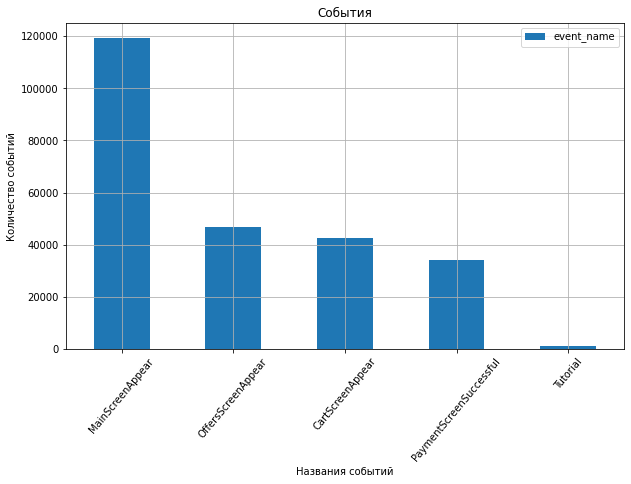

In [15]:
df['event_name'].value_counts().sort_values(ascending = False).plot(kind = 'bar', grid = True, figsize = (10,6))

plt.title('События')
plt.xlabel('Названия событий')
plt.ylabel('Количество событий')
plt.xticks(rotation=50)
plt.legend()
plt.show()

In [16]:
(df.query('event_name == "PaymentScreenSuccessful"').count() / df.query('event_name == "MainScreenAppear"').count()) * 100

event_name         28.646275
id                 28.646275
event_timestamp    28.646275
group              28.646275
date               28.646275
time               28.646275
dtype: float64

**Всего видим 5 событий. При этом подавляющее большинство событий - MainScreenAppear т.е. посещение главной страницы. Всего 1018 раз пользователи проходили туториал. Можно наблюдать, что путь пользователя от первого посещения сайта до оплаты товара проходят 28% пользователей**

### Сколько всего пользователей в логе?

In [17]:
display(f'всего пользователей: {df["id"].nunique()}')

'всего пользователей: 7551'

### Сколько в среднем событий приходится на пользователя?

In [18]:
display(f'на одного пользователя в среднем приходится:\
 {round(df.groupby("id").agg({"event_name" : "count"}).mean()[0])} события')

display(f'медианно на одного пользователя приходится:\
 {round(df.groupby("id").agg({"event_name" : "count"}).median()[0])} событий')


'на одного пользователя в среднем приходится: 32 события'

'медианно на одного пользователя приходится: 20 событий'

**В среднем на одного пользователя приходится 32 события, но по медиане поменьше - 20**

In [19]:
df.groupby("id").agg({"event_name" : "count"})['event_name'].value_counts()

5       260
7       250
6       249
8       240
4       236
       ... 
150       1
364       1
140       1
144       1
1439      1
Name: event_name, Length: 249, dtype: int64

In [20]:
df.groupby("id").agg({"event_name" : "count"}).sort_values(by='event_name', ascending = False).head(20)

,event_name
id,
6304868067479728361,2307
197027893265565660,1998
4623191541214045580,1768
6932517045703054087,1439
1754140665440434215,1221
3337471580007169353,1186
7738058666231999878,888
1055544042902443290,854
4713748699910253089,824


In [21]:
df.query('id == 6304868067479728361')

,event_name,id,event_timestamp,group,date,time
32882,MainScreenAppear,6304868067479728361,2019-08-01 18:01:25,248,2019-08-01,18:01:25
32893,CartScreenAppear,6304868067479728361,2019-08-01 18:01:43,248,2019-08-01,18:01:43
32894,PaymentScreenSuccessful,6304868067479728361,2019-08-01 18:01:43,248,2019-08-01,18:01:43
32896,MainScreenAppear,6304868067479728361,2019-08-01 18:01:44,248,2019-08-01,18:01:44
32897,OffersScreenAppear,6304868067479728361,2019-08-01 18:01:52,248,2019-08-01,18:01:52
...,...,...,...,...,...,...
232189,OffersScreenAppear,6304868067479728361,2019-08-07 14:54:24,248,2019-08-07,14:54:24
232196,CartScreenAppear,6304868067479728361,2019-08-07 14:54:28,248,2019-08-07,14:54:28
232208,OffersScreenAppear,6304868067479728361,2019-08-07 14:54:41,248,2019-08-07,14:54:41
241903,MainScreenAppear,6304868067479728361,2019-08-07 19:26:20,248,2019-08-07,19:26:20


**Есть пользователи, котоыре совершили огромное количество событий**

### Данными за какой период располагаем? 

In [22]:
display(f'минимальная дата {df["date"].min()}')
display(f'максимальная дата {df["date"].max()}')

'минимальная дата 2019-07-25 00:00:00'

'максимальная дата 2019-08-07 00:00:00'

In [23]:
groups = pd.pivot_table(df, values = 'event_name', index = 'date', columns = 'group', aggfunc = {'event_name' : 'count'})
groups

group,246,247,248
date,,,
2019-07-25,4,1,4
2019-07-26,14,8,9
2019-07-27,24,23,8
2019-07-28,33,36,36
2019-07-29,55,58,71
2019-07-30,129,138,145
2019-07-31,620,664,746
2019-08-01,11561,12306,12274
2019-08-02,10946,10990,13618


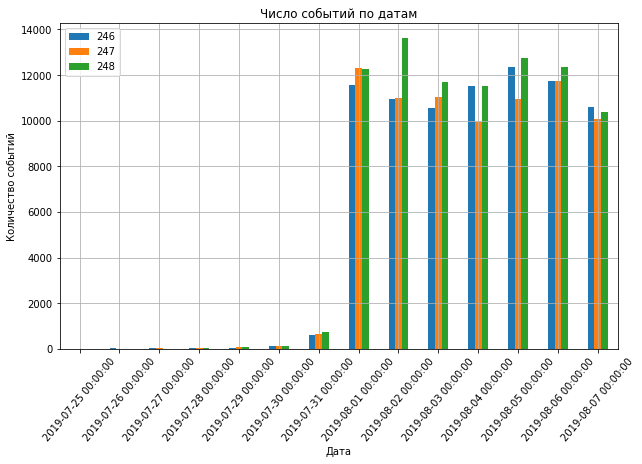

In [24]:
groups.plot(kind = 'bar', grid = True, figsize = (10,6))

plt.title('Число событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=50)
plt.legend()
plt.show()

**Исходя из построенного графика видим, что данные неполные. До 31 июля событий очень мало. Предположу, что можно отбросить данные 1 августа. Таким образом у нас останутся полные данные за 7 дней**

#### Много ли событий и пользователей потеряли, отбросив старые данные?


In [25]:
# отбрасываю старые данные

df_filtered = df.query('date > "2019-07-31"')

In [26]:
len(df.query('date < "2019-07-31"'))

796

Избавляясь от данных до 31 июля мы потеряем всего 796 строк

In [27]:
# проверяю число потеряных событий

display(f'количество событий до фильтрации: {len(df["event_name"])}' )
display(f'количество событий после фильтрации: {len(df_filtered["event_name"])}' )
display(f'доля отброшенных событий: {round((len(df["event_name"])-len(df_filtered["event_name"]) ) / len(df["event_name"]), 4)}' )

'количество событий до фильтрации: 243713'

'количество событий после фильтрации: 240887'

'доля отброшенных событий: 0.0116'

In [28]:
# проверяю количество потеряных пользователей и долю 

display(f'количество пользователей до фильтрации: {df["id"].nunique()} ' )
display(f'количество пользователей после фильтрации: {df_filtered["id"].nunique()} ')
display(f'доля отброшенных пользователей: {round((df["id"].nunique()-df_filtered["id"].nunique() ) / df["id"].nunique(), 4)}' )

'количество пользователей до фильтрации: 7551 '

'количество пользователей после фильтрации: 7534 '

'доля отброшенных пользователей: 0.0023'

In [29]:
print('событийй в группе 246: {}\n'
      'событийй в группе 247: {}\n'
      'событийй в группе 248: {}'\
      .format(len(df_filtered.query("group == 246")),\
              len(df_filtered.query("group == 247")),\
              len(df_filtered.query("group == 248"))))

событийй в группе 246: 79302
событийй в группе 247: 77022
событийй в группе 248: 84563


Для каждой группы осталось достаточно много данных. Можно продолжать работу

In [30]:
# ещё разок можно проверить на наличие дубликатов

df_filtered.duplicated().sum()

0

## Изучить воронку событий


- Какие события есть в логах, как часто они встречаются. 
- Сколько пользователей совершали каждое из этих событий. 
- Какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)?
- На каком шаге теряется больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

In [31]:
events = df_filtered.groupby('event_name').agg({'event_name' : 'count', 'id' : 'nunique'}).sort_values(by = 'id', ascending = False)
events

,event_name,id
event_name,,
MainScreenAppear,117328,7419
OffersScreenAppear,46333,4593
CartScreenAppear,42303,3734
PaymentScreenSuccessful,33918,3539
Tutorial,1005,840


In [32]:
events['percent'] = events['id'].apply(lambda x: round((x / events['id'].max()), 2))
events

,event_name,id,percent
event_name,,,
MainScreenAppear,117328,7419,1.00
OffersScreenAppear,46333,4593,0.62
CartScreenAppear,42303,3734,0.50
PaymentScreenSuccessful,33918,3539,0.48
Tutorial,1005,840,0.11


**Последовательность событий правильная, но обучение оказывается лишним - его мало кто проходит. Обязательным туториал тоже не назвать. Можно от него избавиться**

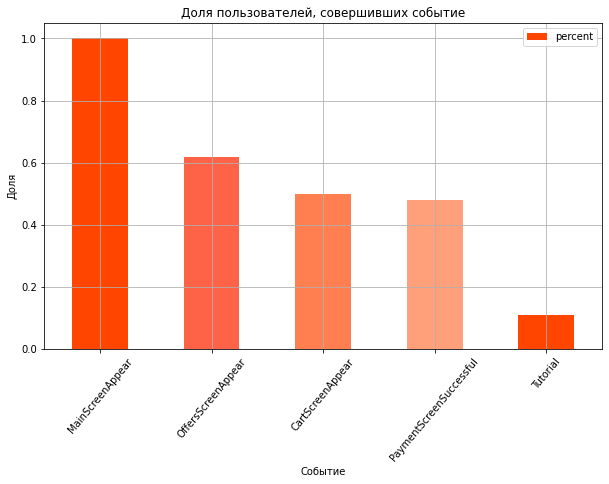

In [33]:
colors = ['orangered', 'tomato', 'coral', 'lightsalmon']
events['percent'].plot(kind = 'bar', grid = True, figsize = (10,6), color = colors)

plt.title('Доля пользователей, совершивших событие')
plt.xlabel('Событие')
plt.ylabel('Доля')
plt.xticks(rotation=50)
plt.legend()
plt.show()

**Видим резкое сокращение пользователей между первым и вторым событием. Однако те, кто дошёл до формирования корзины почти в польном составе дошли и до окна успешной оплаты**

In [34]:
events = events.drop(index = "Tutorial")

In [35]:
# заодно сразу удалю данные с туториалом из базового дф

df_filtered = df_filtered.query('event_name != "Tutorial"')

In [36]:
# считаю конверсию пользователей в следующее событие

events['conversion'] = round(events['id'].shift(-1) / events['id'], 2)
events['conversion'] = events['conversion'].shift(1)
events

,event_name,id,percent,conversion
event_name,,,,
MainScreenAppear,117328,7419,1.00,NaN
OffersScreenAppear,46333,4593,0.62,0.62
CartScreenAppear,42303,3734,0.50,0.81
PaymentScreenSuccessful,33918,3539,0.48,0.95


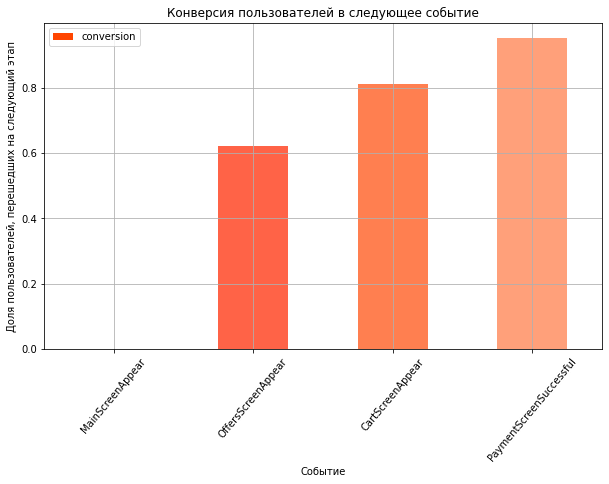

In [37]:
colors = ['orangered', 'tomato', 'coral', 'lightsalmon']
events['conversion'].plot(kind = 'bar', grid = True, figsize = (10,6), color = colors)

plt.title('Конверсия пользователей в следующее событие')
plt.xlabel('Событие')
plt.ylabel('Доля пользователей, перешедших на следующий этап')
plt.xticks(rotation=50)
plt.legend()
plt.show()

**Больше всего пользователей теряется на переходе с первого шага "MainScreenAppear" на второй шаг  "OffersScreenAppear". Иными словами пользователи заходят на главную страницу сайта, но не продвигаются дальше. Между событиями формирования корзины и оплаты заказа разница не велика, многие доходят до конца, в среднем 48% пользователей. Конверсия Перехода с экрана корзины на экран оплаты заказа 95%**

## Изучить результаты эксперимента



- Сколько пользователей в каждой экспериментальной группе?
- А/А-тест.
- Проверка по событиям


In [39]:
print('событий в группе 246: {}\n'
      'событий в группе 247: {}\n'
      'событий в группе 248: {}'\
      .format(len(df_filtered.query("group == 246")),\
              len(df_filtered.query("group == 247")),\
              len(df_filtered.query("group == 248"))))

событий в группе 246: 78985
событий в группе 247: 76684
событий в группе 248: 84213


In [40]:
print('уникальных пользователей в группе 246: {}\n'
      'уникальных пользователей в группе 247: {}\n'
      'уникальных пользователей в группе 248: {}'\
      .format(df_filtered.query("group == 246")['id'].nunique(),\
              df_filtered.query("group == 247")['id'].nunique(),\
              df_filtered.query("group == 248")['id'].nunique()))

уникальных пользователей в группе 246: 2483
уникальных пользователей в группе 247: 2512
уникальных пользователей в группе 248: 2535


Поскольку сравнивать нужно доли выборок, будем использовать z-критерий

H0 = разницы долей пользователей между группами 246 и 247 нет

H1 = разница долей пользователей между группами 246 и 247 есть

In [41]:
   
    alpha = 0.05  
    
    success = [df_filtered.query("group == 246")['id'].nunique(), df_filtered.query("group == 247")['id'].nunique()]
    total = [df_filtered['id'].nunique(), df_filtered['id'].nunique()]

    p1 = success[0] / total[0]
    p2 = success[1] / total[1]

    p_combined = (success[1] + success[0]) / (total[1] + total[0])
    difference = p1-p2
    z_value =  difference / math.sqrt(p_combined * (1 - p_combined) * (1/total[0] + 1/total[1])) 
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2 

    print('p-значение: ', p_value)

    if p_value < alpha:  
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

p-значение:  0.6157227013842994
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Статистически значимой разницы между долями количества пользователей в двух контрольных группах (246 и 247) нет. Следовательно можно считать, что контрольные группы равны между собой**

#### Считаем разницы долей в контрольных группах 


как мы видели выше, самое популярное событие -посещение главной страницы сайта - "MainScreenAppear"

In [42]:
print('пользователей совершивших событие "MainScreenAppear" в группе 246: {}\n'
      'пользователей совершивших событие "MainScreenAppear" в группе 247: {}\n'
      .format(df_filtered.query('group == 246 & event_name == "MainScreenAppear"')['id'].nunique(),\
              df_filtered.query('group == 247 & event_name == "MainScreenAppear"')['id'].nunique()))

пользователей совершивших событие "MainScreenAppear" в группе 246: 2450
пользователей совершивших событие "MainScreenAppear" в группе 247: 2476



In [43]:
print('доля пользователей совершивших событие "MainScreenAppear" в группе 246: {}\n'
      'доля пользователей совершивших событие "MainScreenAppear" в группе 247: {}\n'
      .format(df_filtered.query('group == 246 & event_name == "MainScreenAppear"')['id'].nunique()/\
              df_filtered.query('group == 246')['id'].nunique(),
              df_filtered.query('group == 247 & event_name == "MainScreenAppear"')['id'].nunique()/\
              df_filtered.query('group == 247')['id'].nunique()))

доля пользователей совершивших событие "MainScreenAppear" в группе 246: 0.9867096254530809
доля пользователей совершивших событие "MainScreenAppear" в группе 247: 0.9856687898089171



In [44]:
alpha = 0.55
1 - (1 - alpha)**(1/16) 


0.0486818511574888

In [45]:
# задаю функцию для расчета z-критерия

def stats (group_1, group_2, event):
    
    alpha = 0.55
    iterations = 16
    
    success = [df_filtered.query('event_name == @event & group == @group_1')['id'].nunique(),\
              df_filtered.query('event_name == @event & group == @group_2')['id'].nunique()]
    
    total = [df_filtered.query('group == @group_1')['id'].nunique(),\
            df_filtered.query('group == @group_2')['id'].nunique()]

    p1 = success[0] / total[0]
    p2 = success[1] / total[1]

    p_combined = (success[1] + success[0]) / (total[1] + total[0])
    difference = p1-p2
    z_value =  difference / math.sqrt(p_combined * (1 - p_combined) * (1/total[0] + 1/total[1])) 
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2 

    shidak = 1 - (1 - alpha)**(1/iterations)
    
    if p_value < shidak:  
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

H0 = разницы долей пользователей между группами 246 и 247 в различных событиях нет

H1 = разница долей пользователей между группами 246 и 247 в различных событиях есть

In [46]:
e = df_filtered['event_name'].unique()

for i in e:
    display(i)
    display(stats(246, 247, i)),
    display("*" *50)


'MainScreenAppear'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

'OffersScreenAppear'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

'CartScreenAppear'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

'PaymentScreenSuccessful'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

**По итогам статистических подсчетов видим, что значимых различий между группами А/А нет. Значит, принимаем нулевую гипотезу о том, что их доли не различаются и данные разбиты на группы корректно**

#### Считаем разницу между группами А/В 

H0 = разницы долей пользователей между группами 246 и 248 в различных событиях нет

H1 = разница долей пользователей между группами 246 и 248 в различных событиях есть

In [47]:
e = df_filtered['event_name'].unique()

for i in e:
    display(i)
    display(stats(246, 248, i)),
    display("*" *50)


'MainScreenAppear'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

'OffersScreenAppear'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

'CartScreenAppear'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

'PaymentScreenSuccessful'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

**Статистически значимой разницы между группами 246 и 248 нет. Следовательно, их доли равны**

H0 = разницы долей пользователей между группами 247 и 248 в различных событиях нет

H1 = разница долей пользователей между группами 247 и 248 в различных событиях есть

In [48]:
e = df_filtered['event_name'].unique()

for i in e:
    display(i)
    display(stats(247, 248, i)),
    display("*" *50)


'MainScreenAppear'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

'OffersScreenAppear'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

'CartScreenAppear'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

'PaymentScreenSuccessful'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


None

'**************************************************'

**Статистически значимой разницы между группами 247 и 248 нет. Следовательно, их доли равны**

##### Сравниваем результаты с объединённой контрольной группой.

H0 = разницы долей пользователей между объединенными контрольными группами и экспериментальной группой в различных событиях нет

H1 = разница долей пользователей между объединенными контрольными группами и экспериментальной группой в различных событиях есть

In [49]:
# изменяю базовую функцию и вношу поправку Бонферрони

def stats_aa (group_2, event):
    
    alpha = 0.55  
    iterations = 4
    
    success = [df_filtered.query('group == 246')['id'].nunique() + df_filtered.query('group == 247')['id'].nunique(),\
              df_filtered.query('event_name == @event & group == @group_2')['id'].nunique()]
    
    total = [df_filtered['id'].nunique(),\
            df_filtered.query('group == @group_2')['id'].nunique()]

    p1 = success[0] / total[0]
    p2 = success[1] / total[1]

    p_combined = (success[1] + success[0]) / (total[1] + total[0])
    difference = p1-p2
    z_value =  difference / math.sqrt(p_combined * (1 - p_combined) * (1/total[0] + 1/total[1])) 
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2 

    print('p-значение: ', p_value)

    
    # ввожу поправку Шидака на 16 измерений
    
    #bonferroni = alpha / 4
    shidak = 1 - (1 - alpha)**(1/iterations)
    
    if p_value < shidak:  
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [50]:
e = df_filtered['event_name'].unique()

for i in e:
    display(i)
    display(stats_aa(248, i)),
    display("*" *50)


'MainScreenAppear'

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


None

'**************************************************'

'OffersScreenAppear'

p-значение:  6.030960886249659e-08
Отвергаем нулевую гипотезу: между долями есть значимая разница


None

'**************************************************'

'CartScreenAppear'

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


None

'**************************************************'

'PaymentScreenSuccessful'

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


None

'**************************************************'

**Статистически значимая разница есть, значит, доли объединенной контрольной группы и экспериментальной группы не равны**

## Вывод

В начале были получены довольно неплохие данные. Была проведена предподготовка, заменены форматы даты и времени, созданы дополнительные колонки с датой и временем, удалены дубликаты, переименованы некоторые столбцы. 

Всего в данных 5 событий, из которых обучение почти никто не проходит. Самое массовое событие - посещение главной страницы сайта. До последнего события (оплаты товаров) доходит 28% пользователей. В среднем на одного пользователя приходится 32 события, но по медиане поменьше - 20.

Больше всего пользователей теряется на переходе с первого шага "MainScreenAppear" на второй шаг "OffersScreenAppear". Иными словами пользователи заходят на главную страницу сайта, но не продвигаются дальше. Между событиями формирования корзины и оплаты заказа разница не велика, многие доходят до конца, в среднем 48% пользователей. Конверсия Перехода с экрана корзины на экран оплаты заказа 95%. 

Контрольные группы 246 и 247 статистически не отличаются между собой. Значимой разницы между группами 246-248 и 247-248 также не обнаружено, следовательно изменения шрифта не повлияло на совершение событий пользователями.

При объединении двух контрольных групп и сравнении их с экспериментальной группой статистически значимые отличия есть. Вероятно, это связано с неравным числом выборок, а не с изменением шрифтов